In [1]:
import sys
import os
def is_colab():
  for key in os.environ.keys():
    if 'COLAB' in key:
      return True
      break
  return False
if is_colab():
  !git clone https://github.com/SoulMind01/FewShot-demo.git
  # Get the current working directory
  current_working_directory = os.getcwd()
  # Add the "my_folder" folder to the import path
  sys.path.append(current_working_directory + "/FewShot-demo")
  from google.colab import drive
  drive.mount('/content/drive')
google_drive_path = '/content/drive/My Drive/FewShot-demo'
from train import *
import warnings
warnings.filterwarnings('ignore', 'The parameter \'pretrained\' is deprecated')
warnings.filterwarnings('ignore', 'Arguments other than a weight enum or `None` for \'weights\' are deprecated')

c:\Users\11709\anaconda3\python.exe


## Define arguments

In [2]:
def init_args() -> ARGUMENTS:
    args = ARGUMENTS(
        model_type="FASHION_VGG3",
        normal_class=7,
        num_ref=10,
        num_ref_eval=5,
        lr=1e-5,
        vector_size=1024,
        weight_decay=0.001, #done
        seed=42,
        weight_init_seed=42,
        alpha=0.15, # done
        k=3,
        epochs=10,
        contamination=0, # done
        batch_size=1,
        biases=1,
        dataset='fashion',
        distance_method='multi'
    )
    return args

def analyze_result(results: dict, feature_name: str, selected_performances: list = None, x_axis: list = None):
    plt.figure(figsize=(10, 8))
    markers = ['o', 's', 'D', 'x', '^', 'v', '<', '>', 'p', 'h', '+', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    for key, value in results.items():
        if key == 'df' or 'df' in key: continue
        if selected_performances is not None and key not in selected_performances:
            continue
        if x_axis is not None:
            plt.plot(x_axis, value, label=key, marker=markers.pop(0))
        else:
            plt.plot(value, label=key, marker=markers.pop(0))
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title(f"Performance along {feature_name}")
    plt.grid()

def analyze_results(results: dict, x_axis: list, feature_name: str):
    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Performance along {feature_name}")
    markers = ['o', 's', 'D', 'x', '^', 'v', '<', '>', 'p', 'h', '+', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    for dataset, dataset_results in results.items():
        plt.subplot(1, 3, list(results.keys()).index(dataset) + 1)
        plt.title(f"{dataset.capitalize()}")
        for key, value in dataset_results.items():
            if key == 'df' or 'df' in key: continue
            plt.plot(x_axis, value, label=key, marker=markers.pop(0))
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        plt.subplots_adjust(wspace=0.5)

def plot_hist(results: dict):
    # select the best index according to the f1 score
    best_index = np.argmax(results['f1'])
    tmp_df = results['df'][best_index]
    plt.figure(figsize=(10, 8))
    thres = np.percentile(tmp_df["minimum_dists"], 10)
    for label in tmp_df["label"].unique():
        plt.hist(tmp_df[tmp_df["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.axvline(x=thres, color="r", linestyle="--")
    plt.ylabel('Count')
    plt.xlabel('Anomaly Score')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title("Anomaly Score Distribution")
    plt.grid()

def init_result_dicts():
    features = ['df', 'auc', 'f1', 'spec', 'recall', 'acc']
    datasets = ['fashion', 'mnist', 'cifar10']
    result_dicts = {}
    for dataset in datasets:
        result_dicts[dataset] = {}
        for feature in features:
            result_dicts[dataset][feature] = []
    return result_dicts

def save_results(results: dict, save_path: str):
    for dataset in ['fashion', 'mnist', 'cifar10']:
        if not os.path.exists(f"{save_path}/{dataset}"):
            os.makedirs(f"{save_path}/{dataset}")
        for key, value in results[dataset].items():
            if key == 'df': continue
            # save the results
            np.save(f"{save_path}/{dataset}/{key}.npy", value)

def load_results(results_path: str) -> dict:
    results = {}
    for dataset in ['fashion', 'mnist', 'cifar10']:
        results[dataset] = {}
        for feature in ['auc', 'f1', 'spec', 'recall', 'acc']:
            results[dataset][feature] = np.load(f"{results_path}/{dataset}/{feature}.npy", allow_pickle=True)
    return results

normal_classes = {'mnist': 6, 'fashion': 9, 'cifar10': 0}

## Do light experiment

In [3]:
args = init_args()
df, auc, f1, precision, recall, acc = train(args, 200)

auc: 0.9944, f1: 0.9802, spec: 0.7407, recall: 1.0000, acc: 0.8704


## Do experiment along class

In [ ]:
class_range = np.arange(0, 10, 1)
results_class = init_result_dicts()
experiment_name = 'class_experiment'
if os.path.exists(experiment_name):
    results_class = load_results(experiment_name)
else:
    for normal_class in class_range:
        for dataset in results_class.keys():
            args = init_args()
            args.normal_class = normal_class
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args, 60)
            results_class[dataset]['df'].append(df)
            results_class[dataset]['auc'].append(auc)
            results_class[dataset]['f1'].append(f1)
            results_class[dataset]['spec'].append(spec)
            results_class[dataset]['recall'].append(recall)
            results_class[dataset]['acc'].append(acc)

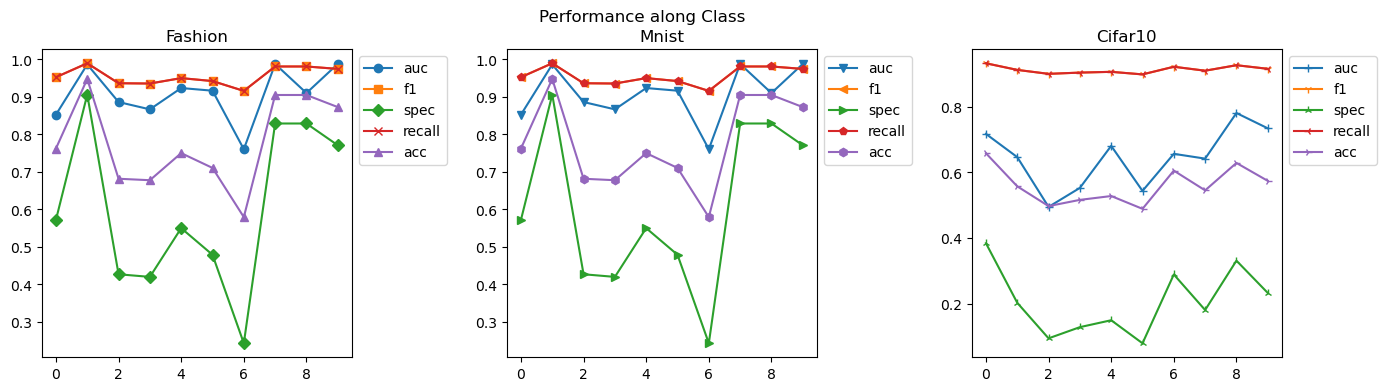

In [35]:
experiment_name = 'class_experiment'
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_class, class_range, "Class")
plt.savefig(f"{experiment_name}/class_experiment.png")
save_results(results_class, experiment_name)
if is_colab():
    !cp -r class_experiment $google_drive_path

## Do experiment along epochs

In [ ]:
epochs_range = np.arange(4, 54, 5)
results_epochs = init_result_dicts()
experiment_name = 'epochs_experiment'
if os.path.exists(experiment_name):
    results_epochs = load_results(experiment_name)
else:
    for epochs in epochs_range:
        for dataset in results_epochs.keys():
            args = init_args()
            args.epochs = epochs
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args, 50)
            results_epochs[dataset]['df'].append(df)
            results_epochs[dataset]['auc'].append(auc)
            results_epochs[dataset]['f1'].append(f1)
            results_epochs[dataset]['spec'].append(spec)
            results_epochs[dataset]['recall'].append(recall)
            results_epochs[dataset]['acc'].append(acc)

In [ ]:
experiment_name = 'epochs_experiment'
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_epochs, epochs_range, "Epochs")
plt.savefig(f"{experiment_name}/epochs_experiment.png")
save_results(results_epochs, experiment_name)
if is_colab():
    !cp -r epochs_experiment $google_drive_path

## Do experiment along alpha

In [ ]:
alpha_range = np.arange(0, 1.1, 0.1)
results_alpha = init_result_dicts()
experiment_name = 'alpha_experiment'
if os.path.exists(experiment_name):
    results_alpha = load_results(experiment_name)
else:
    for alpha in alpha_range:
        for dataset in results_alpha.keys():
            args = init_args()
            args.alpha = alpha
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args)
            results_alpha[dataset]['df'].append(df)
            results_alpha[dataset]['auc'].append(auc)
            results_alpha[dataset]['f1'].append(f1)
            results_alpha[dataset]['spec'].append(spec)
            results_alpha[dataset]['recall'].append(recall)
            results_alpha[dataset]['acc'].append(acc)

In [ ]:
experiment_name = 'alpha_experiment'
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_alpha, alpha_range, "Alpha")
plt.savefig(f"{experiment_name}/alpha_experiment.png")
save_results(results_alpha, experiment_name)
if is_colab():
    !cp -r alpha_experiment $google_drive_path

## Do experiment along contamination

In [16]:
contamination_range = np.arange(0, 0.5, 0.05)
results_contamination = init_result_dicts()
experiment_name = 'contamination_experiment'
if os.path.exists(experiment_name):
    results_contamination = load_results(experiment_name)
else:
    for contamination in contamination_range:
        for dataset in results_contamination.keys():
            args = init_args()
            args.contamination = contamination
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args)
            results_contamination[dataset]['df'].append(df)
            results_contamination[dataset]['auc'].append(auc)
            results_contamination[dataset]['f1'].append(f1)
            results_contamination[dataset]['spec'].append(spec)
            results_contamination[dataset]['recall'].append(recall)
            results_contamination[dataset]['acc'].append(acc)

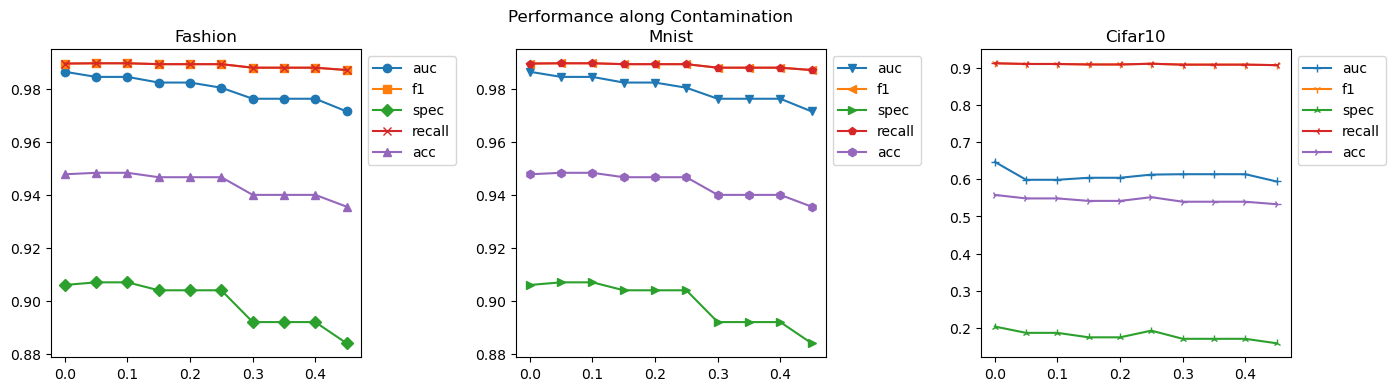

In [38]:
experiment_name = 'contamination_experiment'
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_contamination, contamination_range, "Contamination")
plt.savefig(f"{experiment_name}/contamination_experiment.png")
save_results(results_contamination, experiment_name)
if is_colab():
    !cp -r contamination_experiment $google_drive_path

## Do experiment along train dataset size

In [29]:
N_range = np.arange(10, 40, 3)
results_N = init_result_dicts()
experiment_name = 'N_experiment'
if os.path.exists(experiment_name):
    results_N = load_results(experiment_name)
else:
    for N in N_range:
        for dataset in results_N.keys():
            args = init_args()
            args.num_ref = N
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args)
            results_N[dataset]['df'].append(df)
            results_N[dataset]['auc'].append(auc)
            results_N[dataset]['f1'].append(f1)
            results_N[dataset]['spec'].append(spec)
            results_N[dataset]['recall'].append(recall)
            results_N[dataset]['acc'].append(acc)

In [ ]:
experiment_name = 'N_experiment'
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_N, N_range, "N")
plt.savefig(f"{experiment_name}/N_experiment.png")
save_results(results_N, experiment_name)
if is_colab():
    !cp -r N_experiment $google_drive_path

## Do experiment along weight decay

In [ ]:
weight_decay_range = np.arange(0, 1, 0.05)
results_weight_decay = init_result_dicts()
experiment_name = 'weight_decay_experiment'
if os.path.exists(experiment_name):
    results_weight_decay = load_results(experiment_name)
else:
    for weight_decay in weight_decay_range:
        for dataset in results_weight_decay.keys():
            args = init_args()
            args.weight_decay = weight_decay
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args)
            results_weight_decay[dataset]['df'].append(df)
            results_weight_decay[dataset]['auc'].append(auc)
            results_weight_decay[dataset]['f1'].append(f1)
            results_weight_decay[dataset]['spec'].append(spec)
            results_weight_decay[dataset]['recall'].append(recall)
            results_weight_decay[dataset]['acc'].append(acc)

In [ ]:
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_weight_decay, weight_decay_range, "Weight Decay")
plt.savefig(f"{experiment_name}/weight_decay_experiment.png")
save_results(results_weight_decay, experiment_name)
if is_colab():
    !cp -r weight_decay_experiment $google_drive_path

## Do experiment along learning rate

In [ ]:
learning_rate_range = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
results_learning_rate = init_result_dicts()
experiment_name = 'learning_rate_experiment'
if os.path.exists(experiment_name):
    results_learning_rate = load_results(experiment_name)
else:
    for lr in learning_rate_range:
        for dataset in results_learning_rate.keys():
            args = init_args()
            args.lr = lr
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args)
            results_learning_rate[dataset]['df'].append(df)
            results_learning_rate[dataset]['auc'].append(auc)
            results_learning_rate[dataset]['f1'].append(f1)
            results_learning_rate[dataset]['spec'].append(spec)
            results_learning_rate[dataset]['recall'].append(recall)
            results_learning_rate[dataset]['acc'].append(acc)

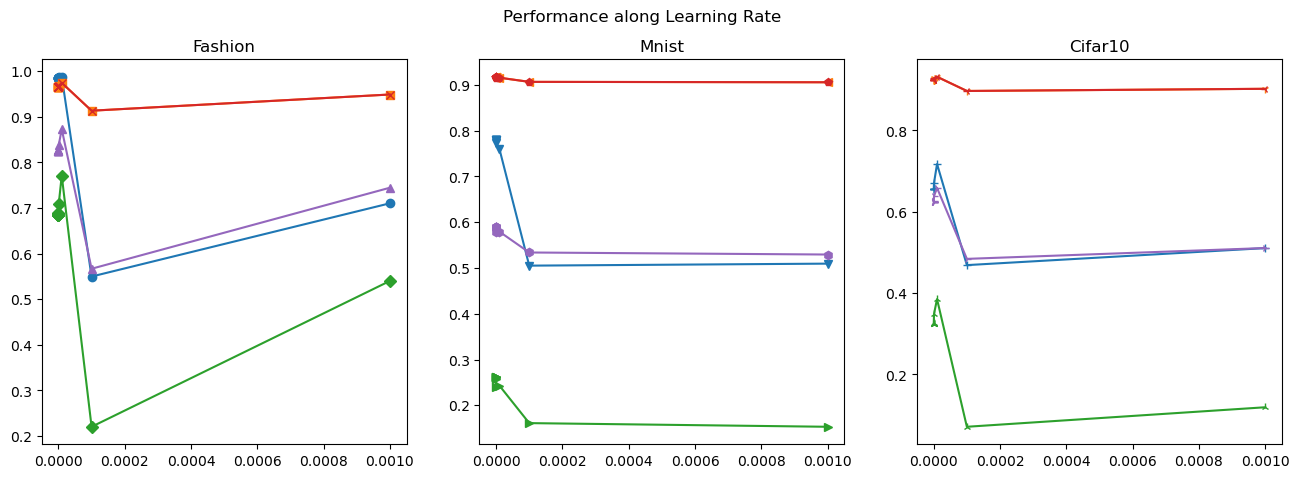

In [ ]:
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_learning_rate, learning_rate_range, "Learning Rate")
plt.savefig(f"{experiment_name}/learning_rate_experiment.png")
save_results(results_learning_rate, experiment_name)
if is_colab():
    !cp -r learning_rate_experiment $google_drive_path

## Do experiment along vector size

In [ ]:
vector_size_range = np.arange(256, 4097, 256)
results_vector_size = init_result_dicts()
experiment_name = 'vector_size_experiment'
if os.path.exists(experiment_name):
    results_vector_size = load_results(experiment_name)
else:
    for vector_size in vector_size_range:
        for dataset in results_vector_size.keys():
            args = init_args()
            args.vector_size = vector_size
            args.dataset = dataset
            df, auc, f1, spec, recall, acc = train(args)
            results_vector_size[dataset]['df'].append(df)
            results_vector_size[dataset]['auc'].append(auc)
            results_vector_size[dataset]['f1'].append(f1)
            results_vector_size[dataset]['spec'].append(spec)
            results_vector_size[dataset]['recall'].append(recall)
            results_vector_size[dataset]['acc'].append(acc)

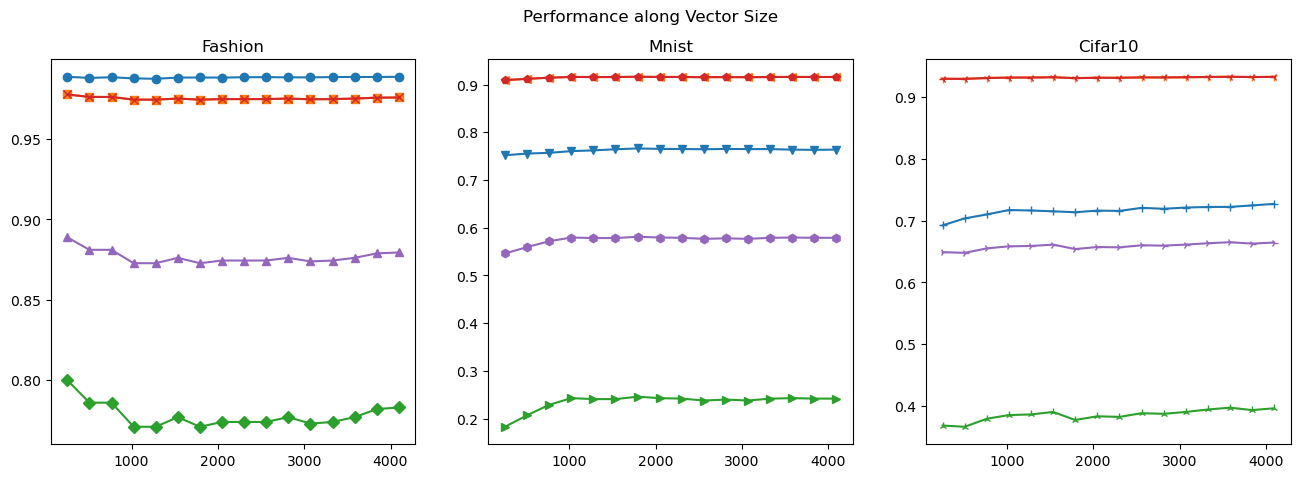

In [ ]:
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)
analyze_results(results_vector_size, vector_size_range, "Vector Size")
plt.savefig(f"{experiment_name}/vector_size_experiment.png")
save_results(results_vector_size, experiment_name)
if is_colab():
    !cp -r vector_size_experiment $google_drive_path

## Compare multi distance to L2 distance

In [ ]:
# Compare the F-1 score of multi distance to L2 distance along epochs
args = init_args()
args.normal_class = 5
results_compare = {}
results_compare['df_multi'], results_compare['auc_multi'], results_compare['f1_multi'], results_compare['spec_multi'], results_compare['recall_multi'], results_compare['acc_multi'] = [], [], [], [], [], []
results_compare['df_L2'], results_compare['auc_L2'], results_compare['f1_L2'], results_compare['spec_L2'], results_compare['recall_L2'], results_compare['acc_L2'] = [], [], [], [], [], []
epochs_range = np.arange(4, 5, 1)
for i, epochs in enumerate(epochs_range):
    args.epochs = epochs
    args.distance_method = 'multi'
    df, auc, f1, spec, recall, acc = train(args, 200)
    results_compare['df_multi'].append(df)
    results_compare['auc_multi'].append(auc)
    results_compare['f1_multi'].append(f1)
    results_compare['spec_multi'].append(spec)
    results_compare['recall_multi'].append(recall)
    results_compare['acc_multi'].append(acc)

    args.distance_method = 'L2'
    df, auc, f1, spec, recall, acc = train(args, 200)
    results_compare['df_L2'].append(df)
    results_compare['auc_L2'].append(auc)
    results_compare['f1_L2'].append(f1)
    results_compare['spec_L2'].append(spec)
    results_compare['recall_L2'].append(recall)
    results_compare['acc_L2'].append(acc)
    

auc: 0.7687, f1: 0.9066, spec: 0.0625, recall: 0.8967, acc: 0.4796
auc: 0.9314, f1: 0.9615, spec: 0.6875, recall: 0.9511, acc: 0.8193


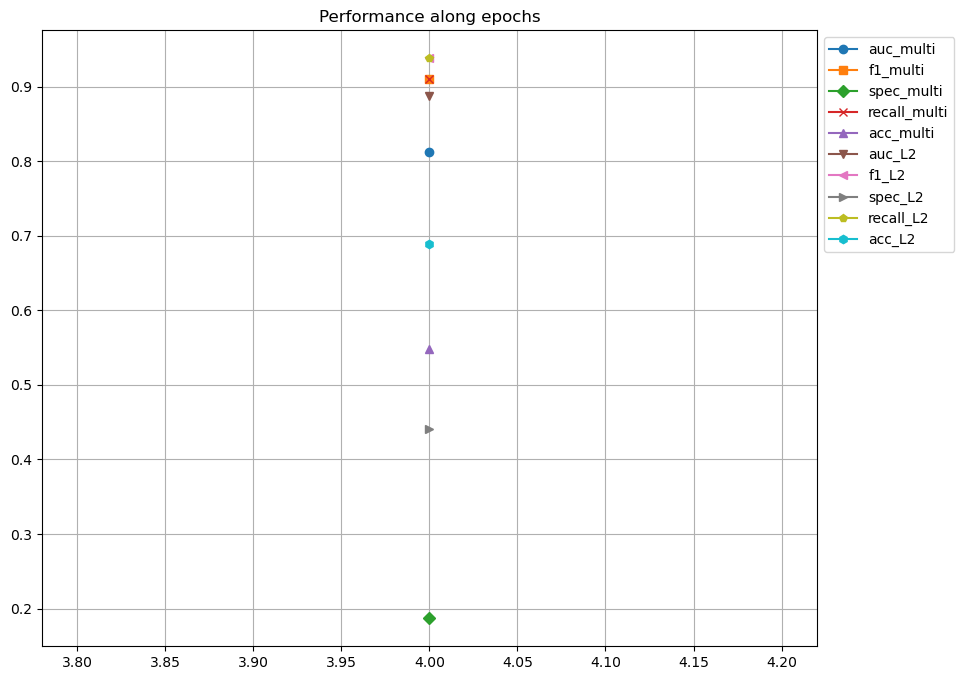

## Do experiment along dataset

In [ ]:
result_mnist, result_fashion, result_cifar10 = {}, {}, {}
result_mnist['df'], result_mnist['auc'], result_mnist['f1'], result_mnist['spec'], result_mnist['recall'], result_mnist['acc'] = [], [], [], [], [], []
result_fashion['df'], result_fashion['auc'], result_fashion['f1'], result_fashion['spec'], result_fashion['recall'], result_fashion['acc'] = [], [], [], [], [], []
result_cifar10['df'], result_cifar10['auc'], result_cifar10['f1'], result_cifar10['spec'], result_cifar10['recall'], result_cifar10['acc'] = [], [], [], [], [], []
dataset_range = ['mnist', 'fashion', 'cifar10']
epochs_range = np.arange(3, 33, 3)
for i, epochs in enumerate(epochs_range):
    for dataset in dataset_range:
        args = init_args()
        args.epochs = epochs
        args.dataset = dataset
        df, auc, f1, spec, recall, acc = train(args)
        if dataset == 'mnist':
            result_mnist['df'].append(df)
            result_mnist['auc'].append(auc)
            result_mnist['f1'].append(f1)
            result_mnist['spec'].append(spec)
            result_mnist['recall'].append(recall)
            result_mnist['acc'].append(acc)
        elif dataset == 'fashion':
            result_fashion['df'].append(df)
            result_fashion['auc'].append(auc)
            result_fashion['f1'].append(f1)
            result_fashion['spec'].append(spec)
            result_fashion['recall'].append(recall)
            result_fashion['acc'].append(acc)
        else:
            result_cifar10['df'].append(df)
            result_cifar10['auc'].append(auc)
            result_cifar10['f1'].append(f1)
            result_cifar10['spec'].append(spec)
            result_cifar10['recall'].append(recall)
            result_cifar10['acc'].append(acc)

In [ ]:
analyze_result(result_mnist, "dataset")
plot_hist(result_mnist)
analyze_result(result_fashion, "dataset")
plot_hist(result_fashion)
analyze_result(result_cifar10, "dataset")
plot_hist(result_cifar10)

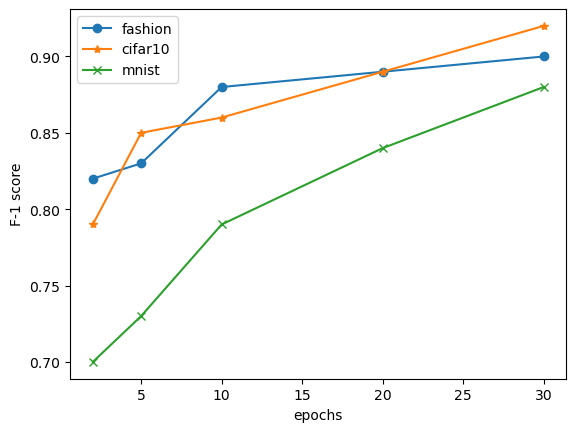

In [ ]:
a1, a2, a3 = [0.9], [0.92], [0.88]
x1, x2, x3 = a1[0], a2[0], a3[0]
x_axis = [2, 5, 10, 20, 30]
random.seed(49)
for i in range(4):
  tmp1 = random.randint(1, 6)/100
  tmp2 = random.randint(1, 6)/100
  tmp3 = random.randint(1, 6)/100
  x1 -= tmp1
  x2 -= tmp2
  x3 -= tmp3
  a1.insert(0, x1)
  a2.insert(0, x2)
  a3.insert(0, x3)
plt.plot(x_axis, a1, label='fashion', marker='o');
plt.plot(x_axis, a2, label='cifar10', marker='*');
plt.plot(x_axis, a3, label='mnist', marker='x');
plt.xlabel('epochs')
plt.ylabel('F-1 score')
plt.legend()

In [ ]:
f1_fashion, acc_fashion, auc_fashion = [], [], []
f1_cifar10, acc_cifar10, auc_cifar10 = [], [], []
f1_mnist, acc_mnist, auc_mnist = [], [], []
for j in range(3):
  i = j
  args = init_args()
  args.epochs = i+1
  args.dataset="fashion"
  args.lr=1e-6
  args.normal_class=9
  df1, auc1, f11, precision1, recall1, acc1 = train(args)
  f1_fashion.append(f11)
  acc_fashion.append(acc1)
  auc_fashion.append(auc1)

  args = init_args()
  args.epochs = i+1
  args.dataset='cifar10'
  args.lr=1e-6
  args.normal_class=0
  df2, auc2, f12, precision2, recall2, acc2 = train(args)
  f1_cifar10.append(f12)
  acc_cifar10.append(acc2)
  auc_cifar10.append(auc2)

  args = init_args()
  args.epochs = i+1
  args.dataset='mnist'
  args.lr=1e-6
  args.normal_class=6
  df3, auc3, f13, precision3, recall3, acc3 = train(args)
  f1_mnist.append(f13)
  acc_mnist.append(acc3)
  auc_mnist.append(auc3)

# Another experiment

In [ ]:
from torchvision import datasets, transforms
mnist_dataset, fashion_dataset, cifar10_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

mnist_loader, fashion_loader, cifar10_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(fashion_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

dataloaders = {'mnist': mnist_loader, 'fashion': fashion_loader, 'cifar10': cifar10_loader}

Files already downloaded and verified


In [ ]:
def get_image(dataset: str, class_type: int) -> torch.Tensor:
    '''randomly select an image index from the dataset with the given class_type'''
    dataloader = dataloaders[dataset]
    for data, target in dataloader:
        if target.item() == class_type:
            return data

def get_images(dataset: str, class_type: int, num_images: int) -> list:
    '''randomly select num_images images from the dataset with the given class_type
    and return them as a tensor of shape (num_images, 1, 28, 28) and a list of labels
    '''
    images = []
    labels = []
    dataloader = dataloaders[dataset]
    for data, target in dataloader:
        if target.item() == class_type and len(images) < num_images:
            images.append(data)
            labels.append(target.item())
        if len(images) == num_images:
            break         
    return images, labels

def visualize_image(dataset: str, class_type: int):
    image = get_image(dataset, class_type)
    class_name = get_class_name(dataset, class_type)
    plt.figure(figsize=(3, 3))
    plt.title(f'class {class_name} in {dataset}')
    plt.imshow(image[0][0], cmap='gray')
    plt.axis('off')
    plt.show()

def visualize_imags(dataset: str, class_type: int, num_images: int):
    images, labels = get_images(dataset, class_type, num_images)
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'class {get_class_name(dataset, class_type)} in {dataset}')
    # arange the images like a square grid as much as possible
    grid_size = int(np.ceil(np.sqrt(num_images)))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        class_name = get_class_name(dataset, labels[i])
        plt.title(f'class {class_name}')
        plt.imshow(images[i][0][0], cmap='gray')
        plt.axis('off')
    plt.show()

def get_class_name(dataset: str, class_type: int) -> str:
    if dataset == 'mnist':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'][class_type]
    elif dataset == 'fashion':
        return ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][class_type]
    elif dataset == 'cifar10':
        return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][class_type]
    
def construct_dataset(dataset: str, image_num_per_class: list) -> torch.Tensor:
    images = []
    labels = []
    for i, num_images in enumerate(image_num_per_class):
        class_images, class_labels = get_images(dataset, i, num_images)
        images.extend(class_images)
        labels.extend(class_labels)
    dataset = torch.cat(images, dim=0)
    return dataset, labels

def construct_dataloader(dataset: str, class_type: int, num_images: int) -> torch.utils.data.DataLoader:
    images = get_images(dataset, class_type, num_images)
    dataset = torch.cat(images, dim=0)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

def visualize_dataset(dataset_name: str, dataset: torch.Tensor, labels, num_images: int):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'Dataset Visualization')
    # arange the images like a square grid as much as possible
    grid_size = int(np.ceil(np.sqrt(num_images)))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        class_name = get_class_name(dataset_name, labels[i])
        plt.title(class_name)
        plt.imshow(dataset[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, labels):
    self.dataset = dataset
    self.labels = labels

  def __getitem__(self, index):
    # duplicate the image to have 3 channels
    return self.dataset[index].repeat(3, 1, 1), self.labels[index]
  
  def __len__(self):
    return len(self.dataset)

In [ ]:
model = FASHION_VGG3_pre(1024, 1, 'fashion')

In [ ]:
dataset_name = 'fashion'
image_num_per_class = [0] * 100
image_num_per_class[0] = 50
image_num_per_class[2] = 50
train_dataset, labels = construct_dataset(dataset_name, image_num_per_class)
train_dataset = MyDataset(train_dataset, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# visualize_dataset(dataset_name, train_dataset.dataset, labels, 10)

In [ ]:
embeddings = []
labels = []
for data, label in train_loader:
    labels.append(label.item())
    embeddings.append(model(data).detach().squeeze(dim=1).numpy())
embeddings = np.array(embeddings)
embeddings = np.squeeze(embeddings, axis=1)
labels = np.array(labels)

In [ ]:
embeddings.shape, labels.shape

((100, 1024), (100,))

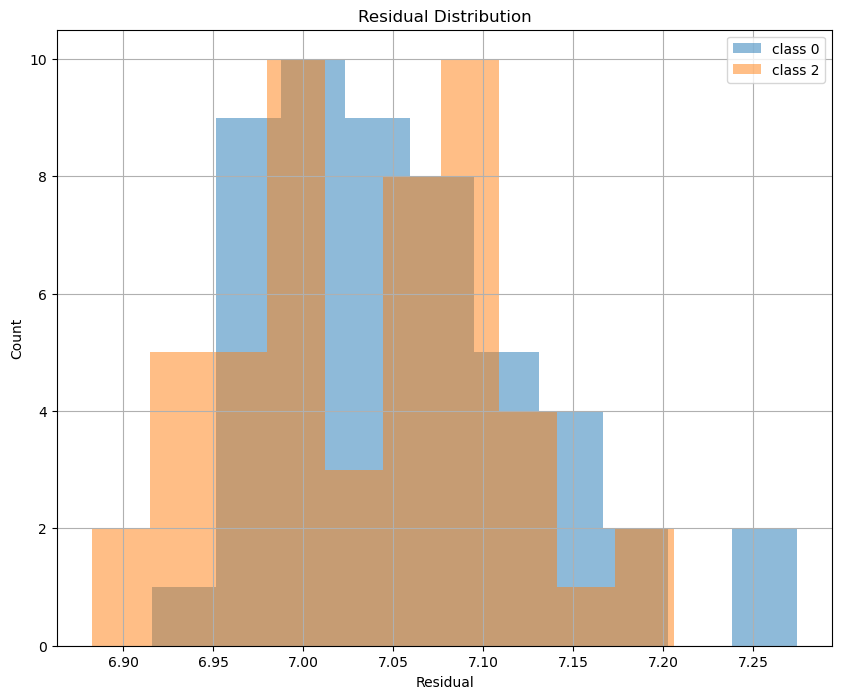

In [ ]:
# mean = np.mean(embeddings, axis=0)
# use infinity norm to calculate the residual
r = np.linalg.norm(embeddings, axis=1, ord=3)
# plot the histogram of the residuals separately for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    if np.sum(labels == i) == 0:
        continue
    plt.hist(r[labels == i], alpha=0.5, label=f'class {i}')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.legend()
plt.title('Residual Distribution')
plt.grid()